Qual é o desempenho máximo que consigo obter usando apenas o histórico do próprio preço do CEPEA, sem informações externas?

-> Modelo 1 — ETS (Holt-Winters / ETS automático)

Representa:

Suavização exponencial

Literatura CEPEA clássica

Muito forte como benchmark

-> Modelo 2 — ARIMA (em log ou retornos)

Representa:

Box–Jenkins

Econometria tradicional

Mesmo que perca, é essencial


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")


In [39]:
df = pd.read_excel('data/serie_cafe_cepea_mensal.xlsx')
df.rename(columns = {
    'Data': 'date',
    'À vista R$': 'price_brl',
    'À vista US$': 'price_usd'
}, inplace = True)
df["log_price_brl"] = np.log(df["price_brl"])

In [40]:
def walk_forward_forecast(
    series,
    model_func,
    start_train_idx,
    horizon
):
    """
    series: pandas Series (log-price mensal)
    model_func: função que recebe série de treino e horizonte e retorna previsão
    start_train_idx: índice inicial do walk-forward
    horizon: horizonte de previsão (int)
    """
    
    forecasts = []
    actuals = []
    dates = []

    for t in range(start_train_idx, len(series) - horizon):
        train = series.iloc[:t]
        test = series.iloc[t + horizon]

        y_hat = model_func(train, horizon)

        forecasts.append(y_hat)
        actuals.append(test)
        dates.append(series.index[t + horizon])

    return pd.DataFrame({
        "date": dates,
        "y_true": actuals,
        "y_pred": forecasts
    }).set_index("date")


def forecast_metrics(df):
    rmse = np.sqrt(np.mean((df.y_true - df.y_pred) ** 2))
    mae = np.mean(np.abs(df.y_true - df.y_pred))
    mape = np.mean(np.abs((df.y_true - df.y_pred) / df.y_true)) * 100

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }


def ets_model(train_series, horizon):
    model = ExponentialSmoothing(
        train_series,
        trend="add",
        seasonal="add",
        seasonal_periods=12
    )
    fitted = model.fit(optimized=True)
    forecast = fitted.forecast(horizon)
    return forecast.iloc[-1]




In [46]:
series = df["log_price_brl"].copy()
series.index = df['date']
series = series.sort_index()

series.head()


date
1996-09-01    4.760634
1996-10-01    4.759692
1996-11-01    4.781054
1996-12-01    4.837234
1997-01-01    5.073735
Name: log_price_brl, dtype: float64

In [47]:
start_train_idx = series.index.searchsorted("2018-01-01")

print("Índice inicial:", start_train_idx)
print("Data inicial:", series.index[start_train_idx])


Índice inicial: 256
Data inicial: 2018-01-01 00:00:00


In [48]:
horizons = [1, 3, 6]

ets_results = {}

for h in horizons:
    df_pred = walk_forward_forecast(
        series=series,
        model_func=ets_model,
        start_train_idx=start_train_idx,
        horizon=h
    )
    ets_results[h] = df_pred

In [49]:
for h, df_pred in ets_results.items():
    print(f"Horizonte {h} mês(es):")
    print(forecast_metrics(df_pred))
    print()


Horizonte 1 mês(es):
{'RMSE': 0.12492929478468541, 'MAE': 0.09834329489380232, 'MAPE': 1.4374107240351885}

Horizonte 3 mês(es):
{'RMSE': 0.18841146339303197, 'MAE': 0.15305997085375822, 'MAPE': 2.2078073166961016}

Horizonte 6 mês(es):
{'RMSE': 0.27326586323362556, 'MAE': 0.2198754489894578, 'MAPE': 3.1585587059842526}



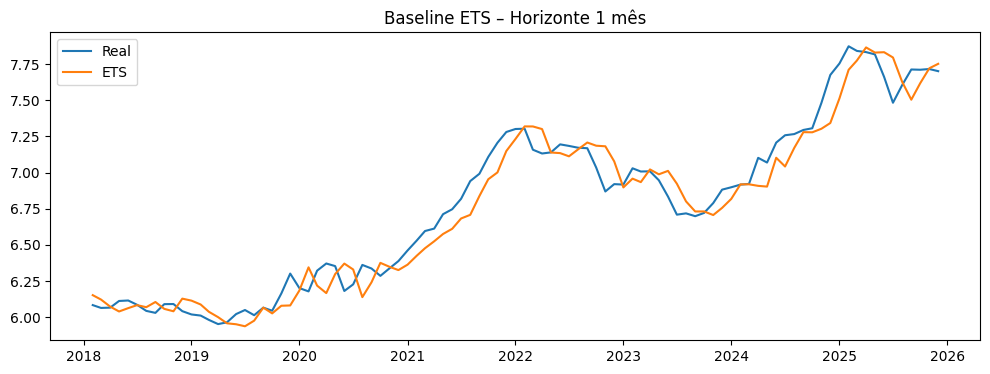

In [ ]:
df_plot = ets_results[1]

plt.figure(figsize=(12,4))
plt.plot(df_plot.y_true, label="Real")
plt.plot(df_plot.y_pred, label="ETS")
plt.legend()
plt.title("Baseline ETS – Horizonte 1 mês")
plt.show()
